# MLVC Exercise 1

This notebook contains the first exercise of the Machine Learning for Visual Computing (193.189) lecture at TU Wien. Assignment via TUWEL. Please be aware of the deadlines in TUWEL.

* Upload a zip-file with the required programms. The programming language is python.
    1. Single Layer Perceptron --> `solutions/perceptron.py`
    2. Multi Layer Perceptron --> `solutions/mlp.py`
    3. Convolutional Neural Network --> `solutions/cnn.py`
* If you needed additional conda or pip packages add an anaconda environment.yml to the zip-file
    1. conda env export > environment.yml
    2. See --> https://conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html#sharing-an-environment

### Conda instructions

1. conda create --name MLVC python=3.11
2. conda activate MLVC
3. Install the correct version of pytorch:
    - CPU: python -m pip install torch torchvision --index-url https://download.pytorch.org/whl/cpu
    - GPU: python -m pip install torch torchvision --index-url https://download.pytorch.org/whl/cu129
4. python -m pip install pillow matplotlib tqdm torchinfo pandas ipykernel nbformat ipywidgets scikit-learn tabulate seaborn umap-learn cvxopt
5. Add python kernel to Jupyter Notebooks
    - python -m ipykernel install --user --name MLVC --display-name "Python (mlvc)”

### Note 1: You may reuse the conda environments for all exercises!
### Note 2: You may also use different package managers (e.g. pip, mamba, ...)!
### Note 3: You do not need to exactly match the expected results: similar performance (±0.2 Misclassification Rate or ±20% Accuracy) is sufficient.

### **Please update your group number in the filename (_X) and only upload your solutions folder.**

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm, trange
from tabulate import tabulate
import seaborn as sns
import json
import random
import torch
from collections import OrderedDict
from utils import pick_device, print_device_info

np.set_printoptions(suppress=True)

# General setting for the ipynb
NUM_SAMPLES = 10000  # Number of training samples that will be generated, do not exceed 25.000 on the TUWEL Jupyter Notebooks (will crash kernel)
TEST_RATIO = 0.9  # Percentage of the generated samples that are used for training (rest is used for testing). [0, 1]

random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

device = pick_device()
print_device_info(device)

Using Apple MPS device


## Generate and Prepare Data

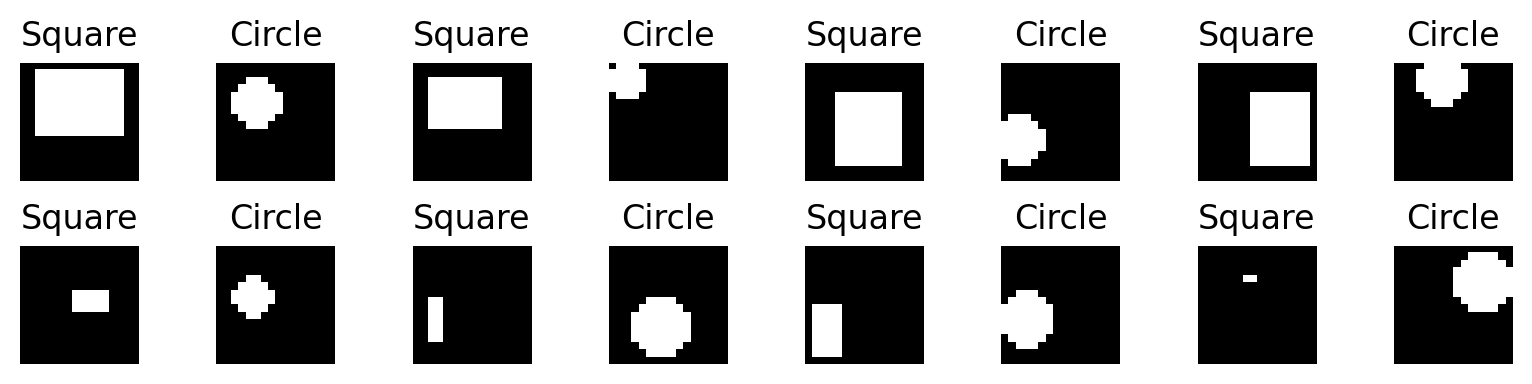

(9000, 256) (9000,) (1000, 256) (1000,)


In [2]:
# Generate the dataset using numpy and pillow

from utils import Dataset

(dataset_train, labels_train), (dataset_test, labels_test) = Dataset(
    NUM_SAMPLES, TEST_RATIO
)

fig, axs = plt.subplots(2, 8, figsize=(8, 2), dpi=200)

for i, ax in enumerate(axs.reshape(-1)):
    ax.imshow(dataset_train[i, :].reshape((16, 16)), cmap="gray")
    ax.set_title("Circle" if labels_train[i] == -1 else "Square")
    ax.axis("off")

plt.tight_layout()
plt.show()
print(dataset_train.shape, labels_train.shape, dataset_test.shape, labels_test.shape)

## 1. Perceptron (10 Points)

The following code works only, if corresponding definitions in the 'solutions' folder are complete. Look at the 'ToDo' comments in the corresponding files.

In [3]:
from solutions.perceptron import Perceptron
from utils import plot_results_perceptron

100%|██████████| 100/100 [00:00<00:00, 5328.74it/s]


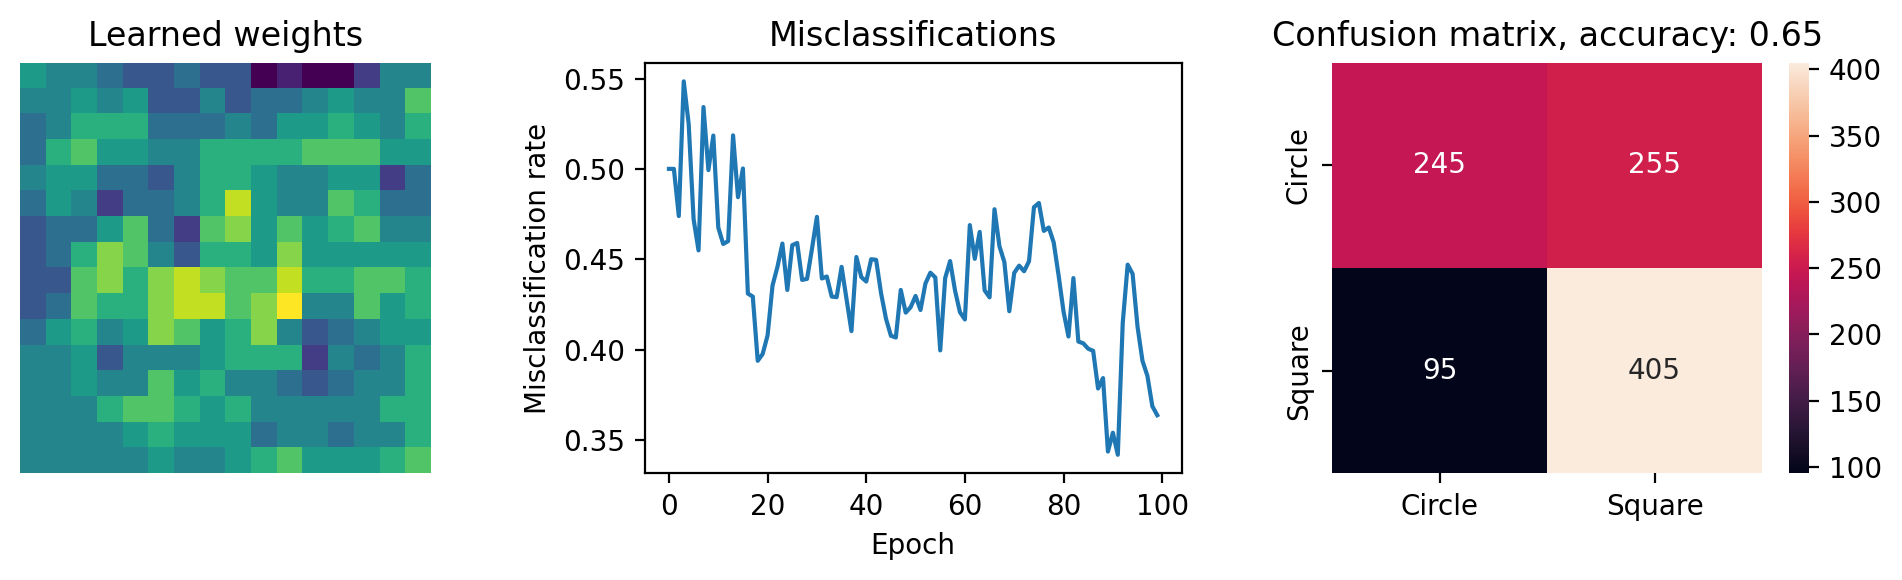

In [4]:
perceptron = Perceptron(lr=0.5, epochs=100)

miss_list = perceptron.fit(dataset_train, labels_train)

# convert the miss_list to a miss_rate
miss_list = np.array(miss_list)
miss_list = miss_list / dataset_train.shape[0]

y_pred = perceptron.predict(dataset_test)

plot_results_perceptron(perceptron.w[:256], miss_list, labels_test, y_pred)

#### Perceptron Expected Results (Trained: 10.000 Samples, 100 Epochs, 0.5 LR)
Left: Example weights of the Perceptron.

Middle: Example graph of the missclassifications during training, per epoch.

Right: Confusion matrix of the trained Perceptron.

**Note**: As the Perceptron is not capable of separating the data, we do not expect a high accuracy.

<div style="display:flex; justify-content:center; background-color:white;">
  <div style="text-align:center; padding:10px;">
    <img src="assets/weights_and_missclassifications_SLP.png" style="height:100%; width:auto;">
  </div>
</div>

## 2. Multi-Layer Perceptron (10 Points)

The following code works only, if corresponding definitions in the 'solutions' folder are complete. Look at the 'ToDo' comments in the corresponding files.

In [5]:
from solutions.mlp import MultiLayerPerceptron
from utils import plot_results_mlp_cnn

In [6]:
layers_spec = [
    {"type": "fc", "in_channels": 256, "out_channels": 32},
    {"type": "act", "name": "sigmoid"},
    {"type": "fc", "in_channels": 32, "out_channels": 16},
    {"type": "act", "name": "sigmoid"},
    {"type": "fc", "in_channels": 16, "out_channels": 1},
    {"type": "act", "name": "sigmoid"}
]

labels_train[labels_train == -1] = 0
labels_test[labels_test == -1] = 0

MLP = MultiLayerPerceptron(layers_spec=layers_spec)

MLP.fit(dataset_train, labels_train, dataset_test, labels_test, epochs=20, lr=0.1)

Epoch 20 - Loss (Train) 0.00035: 100%|██████████| 20/20 [00:07<00:00,  2.59it/s]


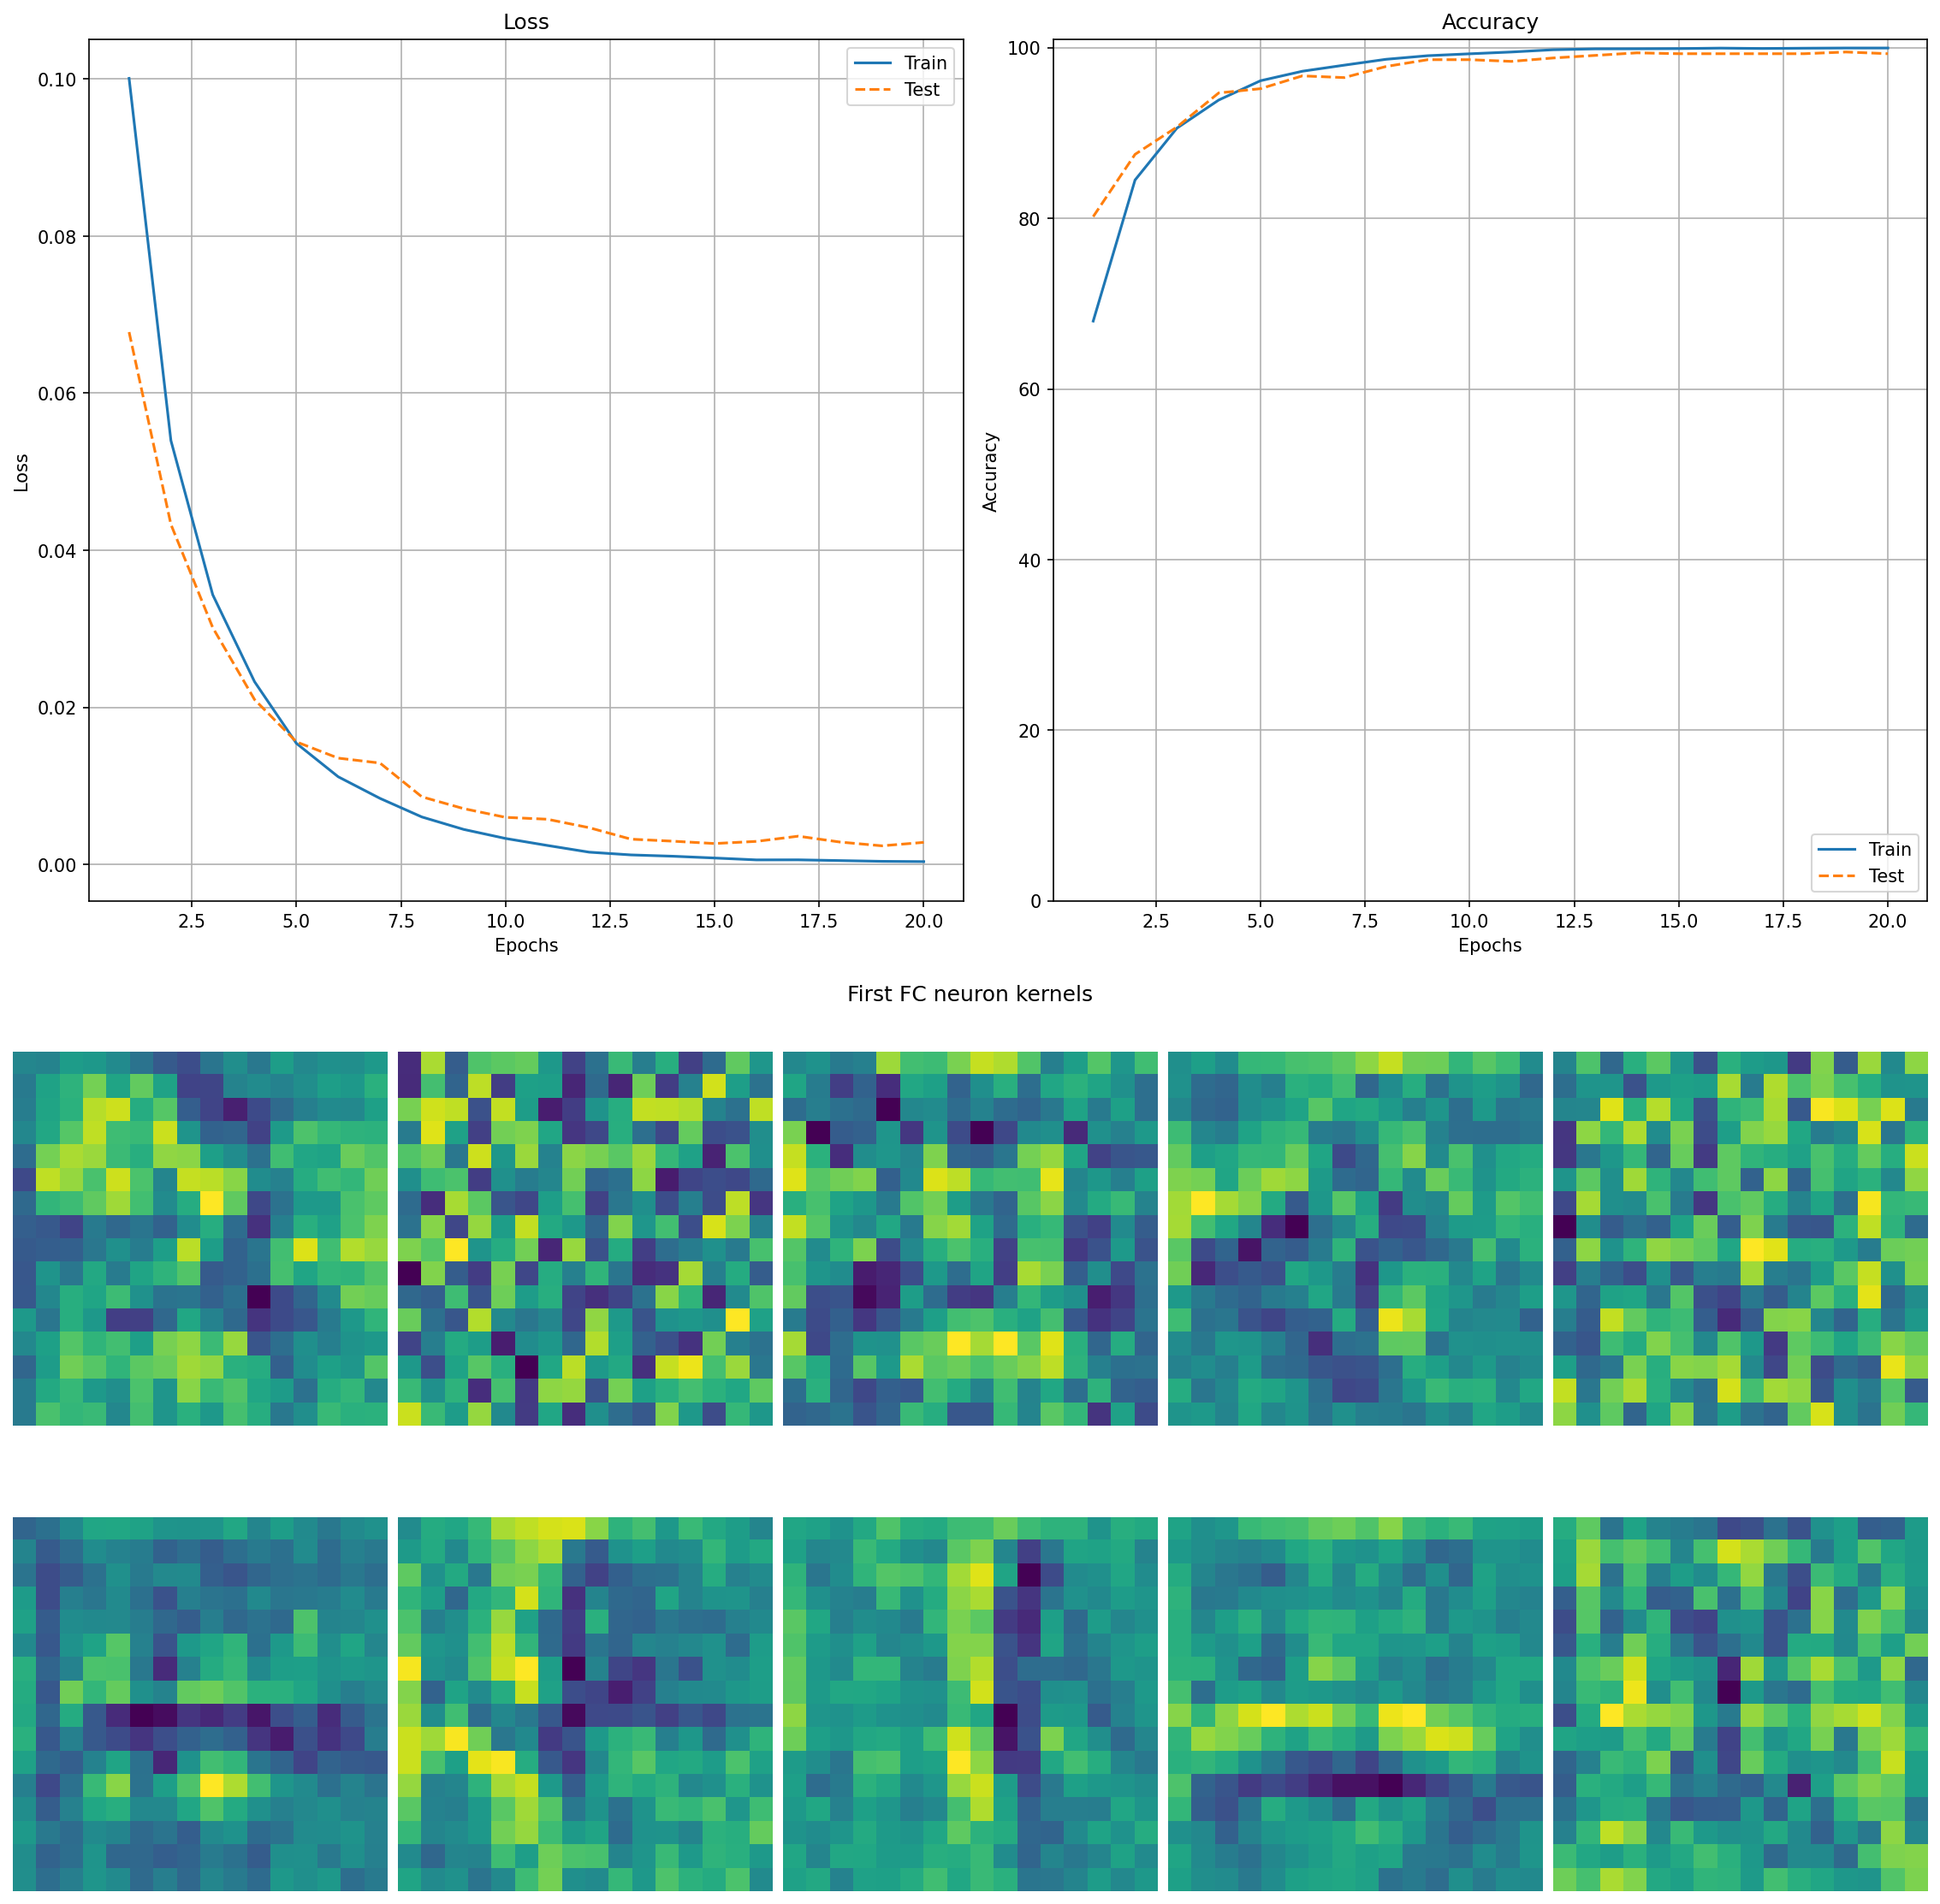

In [7]:
plot_results_mlp_cnn(MLP)

#### Multi-Layer Perceptron Expected Results (Trained: 10.000 Samples, 20 Epochs, 0.1 LR)
Top-Left: Train and test loss over the training.

Top-Right: Train and test accuracy of the training.

Bottom: Visualization of the Fully-Connected layers.

**Note**: The MLP is capable of seperating the data, however, due to the lack of bias it requires approx. 13 epochs to do so.

<div style="display:flex; justify-content:center; background-color:white;">
  <div style="text-align:center; padding:10px;">
    <img src="assets/weights_and_accuracy_MLP.png" style="height:100%; width:auto;">
  </div>
</div>

## 3. Convolutional Neural Network (10 Points)

The following code works only, if corresponding definitions in the 'solutions' folder are complete. Look at the 'ToDo' comments in the corresponding files.

In [9]:
from solutions.cnn import ConvolutionalNeuralNetwork
from utils import plot_results_mlp_cnn

In [10]:
input_shape = (1, 16, 16)

conv_spec = [
    {"type": "conv", "in_channels": 1, "out_channels": 4, "kernel": 3, "stride": 1, "pad": 1},
    {"type": "act", "name": "tanh"},
    {"type": "pool", "kernel": 2, "stride": 2},
    {"type": "conv", "in_channels": 4, "out_channels": 8, "kernel": 3, "stride": 1, "pad": 1},
    {"type": "act", "name": "tanh"},
    {"type": "pool", "kernel": 2, "stride": 2},
]

# first FC in_dim can be set to None; it will be filled based on conv output shape
fc_layers_spec = [
    {"type": "fc", "in_channels": 128, "out_channels": 1},
    {"type": "act", "name": "sigmoid"}
]

labels_train[labels_train == -1] = 0
labels_test[labels_test == -1] = 0

CNN = ConvolutionalNeuralNetwork(conv_spec, fc_layers_spec, input_shape)

CNN.fit(dataset_train, labels_train, dataset_test, labels_test, epochs=10, lr=0.1)

Epoch 10 - Loss (Train) 0.00003: 100%|██████████| 10/10 [00:27<00:00,  2.76s/it]


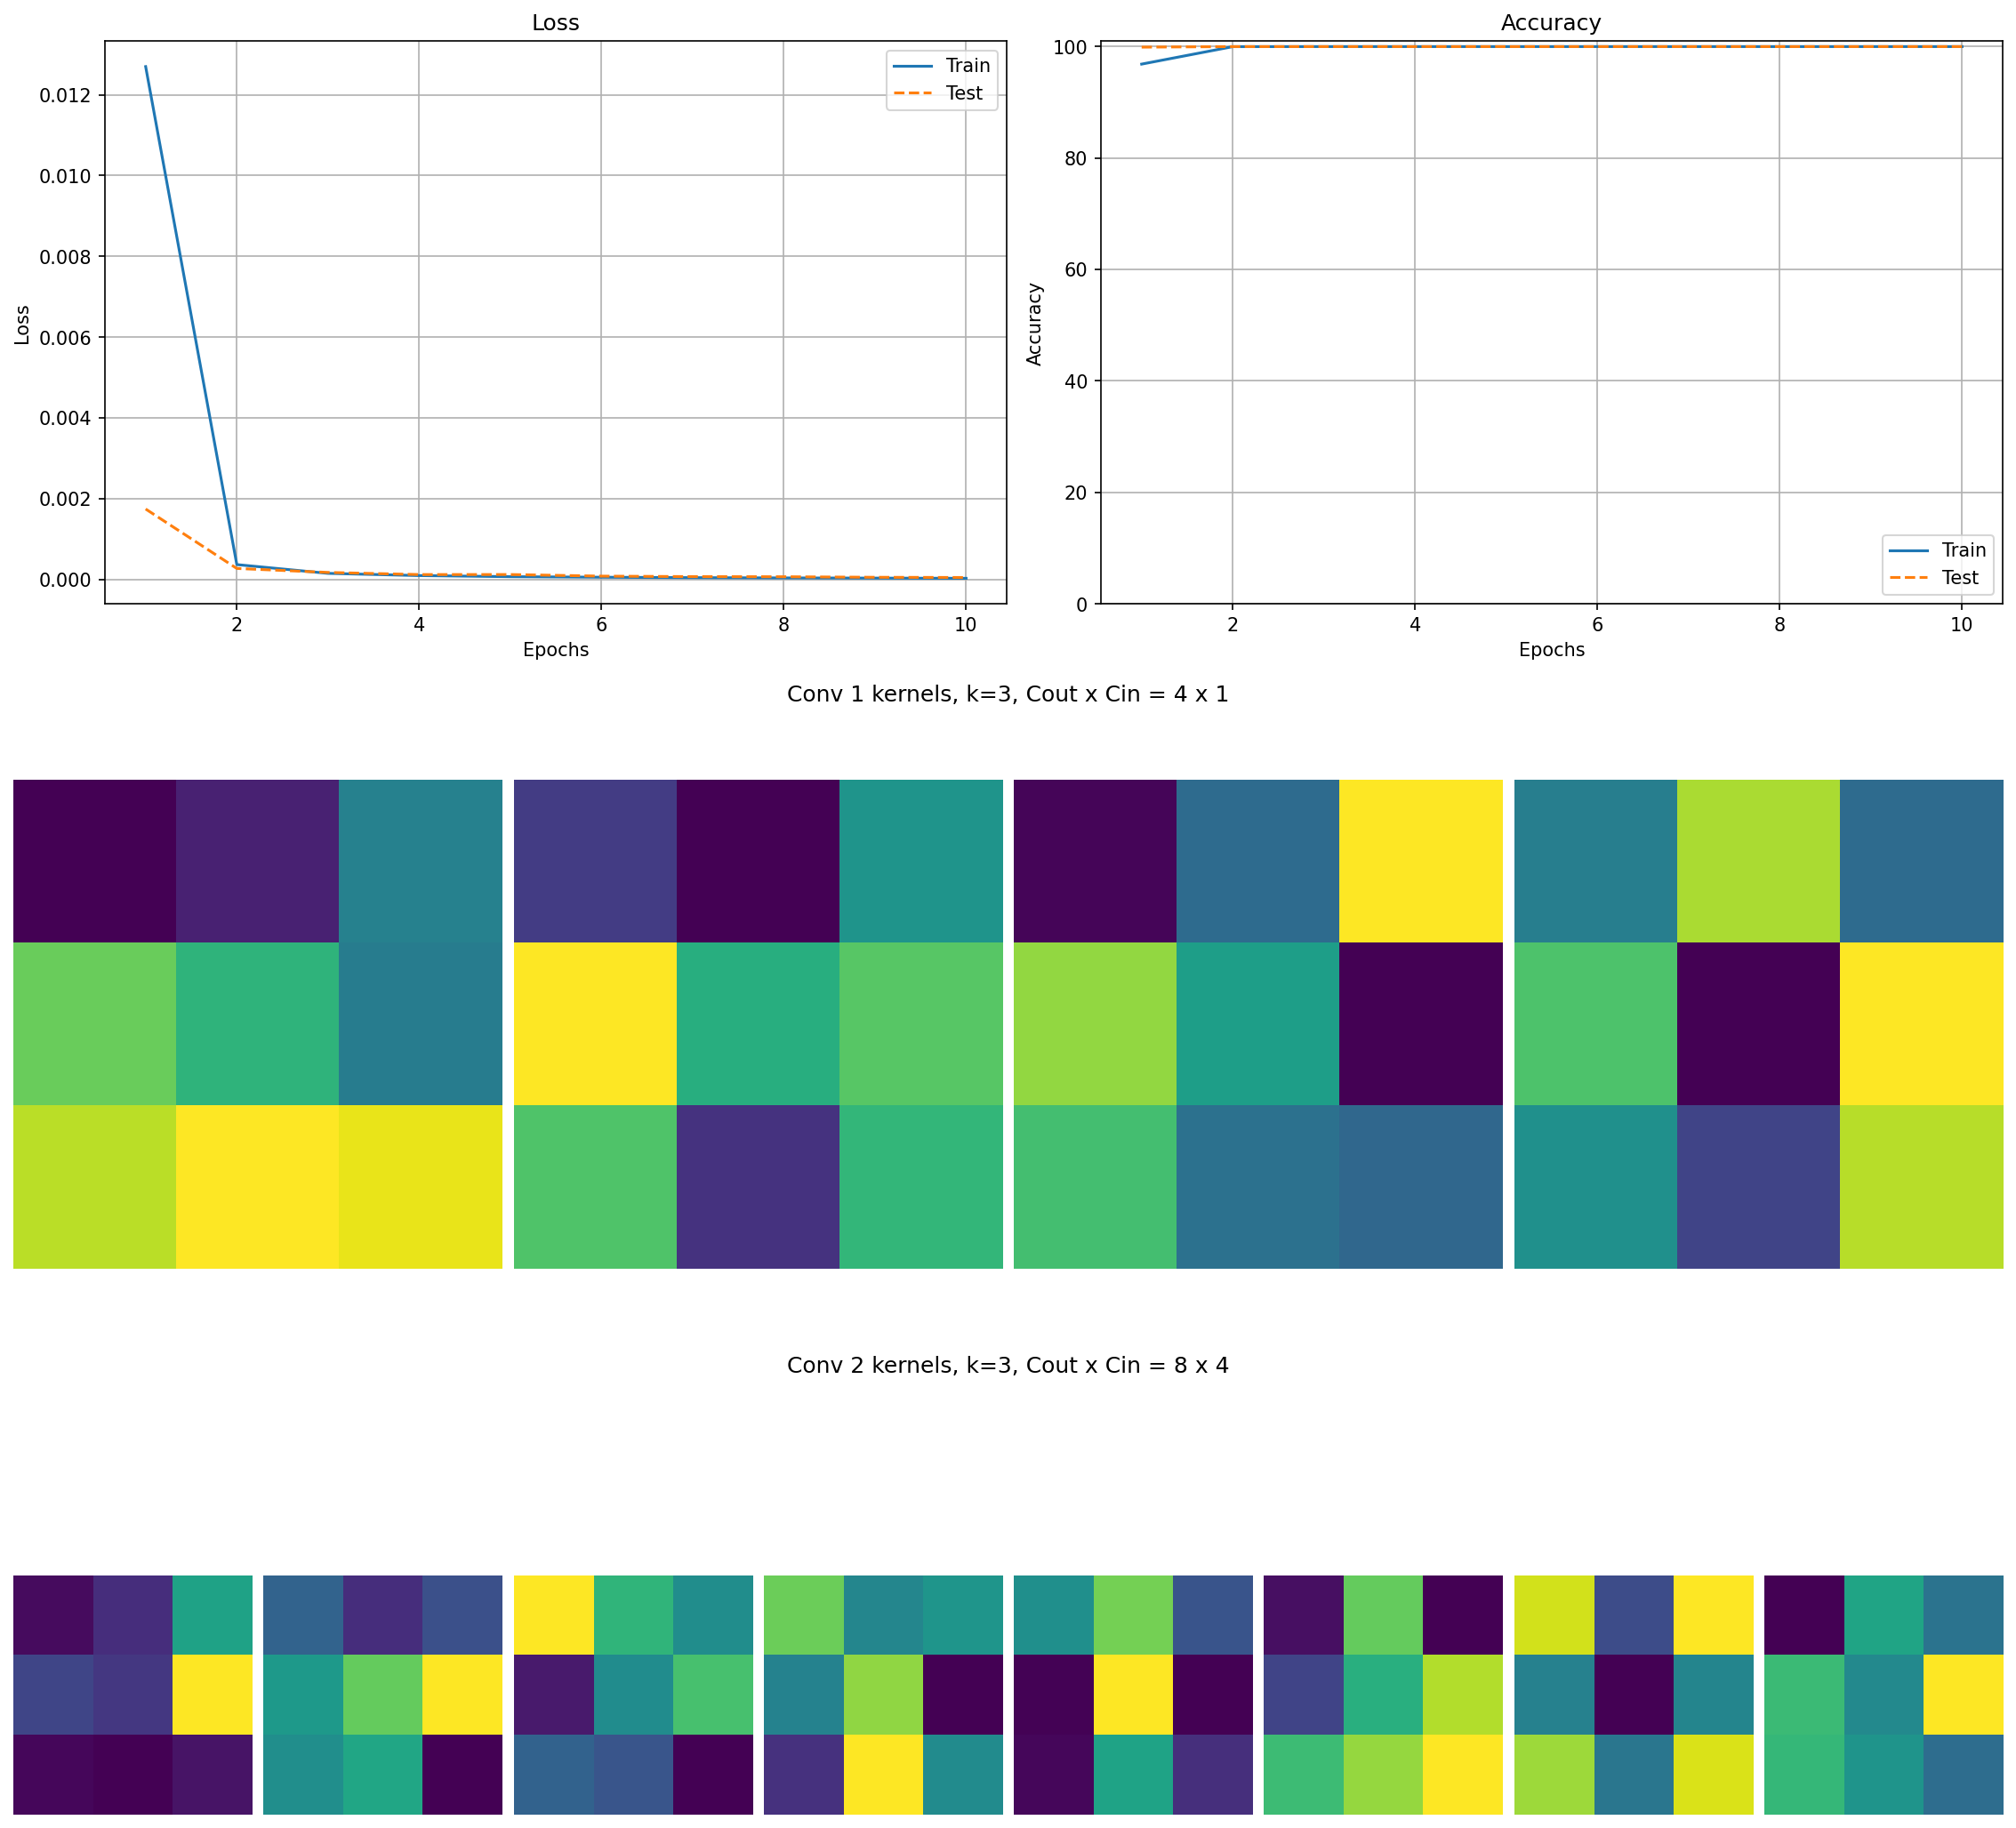

In [11]:
plot_results_mlp_cnn(CNN)

#### Convolutional Neural Network + MLP Expected Results (Trained: 10.000 Samples, 10 Epochs, 0.1 LR)
Top-Left: Train and test loss over the training.

Top-Right: Train and test accuracy of the training.

Bottom: Visualization of the Convolutional layers.

**Note**: The CNN+MLP is capable of seperating the data and due to the inductive bias only requires approx. 2 epochs to do so.

<div style="display:flex; justify-content:center; background-color:white;">
  <div style="text-align:center; padding:10px;">
    <img src="assets/weights_and_accuracy_CNN.png" style="height:100%; width:auto;">
  </div>
</div>